In [66]:
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import os
from pathlib import Path
import pandas as pd
import matplotlib.pyplot as plt
import subprocess
import pickle
import os
from pathlib import Path
import mygene

In [67]:
wd_dir = '/beegfs/scratch/ric.broccoli/kubacki.michal/SRF_CUTandTAG/custom_pipeline'
os.chdir(wd_dir)

# Get the current working directory
current_dir = os.getcwd()

In [68]:
cpg_file = "DATA/cpg_islands.bed"

In [69]:
# Path to your CpG islands file (you'll need to provide this)
cpg_file = "DATA/cpg_islands.bed"

# Get all peak files for each condition
results_dir = Path("results/peaks")


In [70]:
# Read cpg_file
cpg_df = pd.read_csv(cpg_file, sep='\t', header=None)
cpg_df.head()

,0,1,2,3,4,5
0,chr1,3531624,3531843,611,CpG:,27
1,chr1,3670619,3671074,613,CpG:,34
2,chr1,3671654,3672156,613,CpG:,45
3,chr1,4491701,4493673,619,CpG:,165
4,chr1,4496947,4497608,619,CpG:,47


In [71]:
# Read sample sheets to get the peak files
exo_samples = pd.read_csv("DATA/EXOGENOUS_sample_sheet.csv")
endo_samples = pd.read_csv("DATA/ENDOGENOUS_sample_sheet.csv")


# Filter for NEU samples only
exo_samples_nsc = exo_samples[exo_samples['Tissue'] == 'NSC']
endo_samples_nsc = endo_samples[
    (endo_samples['Tissue'] == 'NSC') & 
    (endo_samples['Factor'] != 'IgG')
]


# Filter for NEU samples only
exo_samples_neurons = exo_samples[exo_samples['Tissue'] == 'Neuron']
endo_samples_neurons = endo_samples[
    (endo_samples['Tissue'] == 'Neuron') & 
    (endo_samples['Factor'] != 'IgG')
]

In [72]:
print(exo_samples_nsc.shape)
print(endo_samples_nsc.shape)

print(exo_samples_nsc.shape)
print(endo_samples_nsc.shape)

(3, 8)
(3, 8)
(3, 8)
(3, 8)


# Functions

In [73]:
def filter_standard_chromosomes(input_file, output_file):
    """
    Filter BED file to keep only standard chromosomes (chr1-chr22, chrX, chrY, chrM)
    """
    # Count total peaks
    total = subprocess.run(f"wc -l {input_file}", shell=True, capture_output=True, text=True)
    total = int(total.stdout.split()[0])
    
    # Filter and count remaining peaks
    cmd = f"grep -P '^chr([1-9]|1[0-9]|2[0-2]|X|Y|M)\t' {input_file} > {output_file}"
    subprocess.run(cmd, shell=True)
    
    filtered = subprocess.run(f"wc -l {output_file}", shell=True, capture_output=True, text=True)
    filtered = int(filtered.stdout.split()[0])
    
    print(f"Filtered {input_file}: kept {filtered}/{total} peaks ({filtered/total*100:.1f}%)")

In [74]:
def calculate_peak_cpg_coverage_exact(peak_file, cpg_file):
    """
    Calculate what percentage of each peak overlaps with CpG islands
    """
    # Use bedtools intersect to find overlaps
    cmd = f"bedtools intersect -a {peak_file} -b {cpg_file} -wao"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    
    # Parse the output
    overlaps = []
    for line in result.stdout.strip().split('\n'):
        fields = line.split('\t')
        if len(fields) >= 13:  # Ensure we have enough fields
            # peak_length = int(fields[2]) - int(fields[1])
            cpg_length = abs(int(fields[2]) - int(fields[1]))
            overlap_length = int(fields[-1])
            if cpg_length > 0:
                coverage_percent = (overlap_length / cpg_length) * 100
                overlaps.append(coverage_percent)
    
    return overlaps

In [75]:
def calculate_peak_cpg_coverage(peak_file, cpg_file, extend):
    """
    Calculate what percentage of each peak overlaps with CpG islands
    CpG islands are extended by 300bp on each side
    """
    # First extend CpG islands by 300bp on each side
    # Create a temporary extended CpG file
    cmd_extend = f"bedtools slop -i {cpg_file} -g DATA/genome.size -b {extend} > temp_extended_cpg.bed"
    subprocess.run(cmd_extend, shell=True)
    
    # Use bedtools intersect with extended CpG islands
    cmd = f"bedtools intersect -a {peak_file} -b temp_extended_cpg.bed -wao"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    
    # Clean up temporary file
    subprocess.run("rm temp_extended_cpg.bed", shell=True)
    
    # Parse the output
    overlaps = []
    for line in result.stdout.strip().split('\n'):
        fields = line.split('\t')
        if len(fields) >= 13:  # Ensure we have enough fields
            cpg_length = abs(int(fields[2]) - int(fields[1]))  # CpG island length
            overlap_length = int(fields[-1])
            if cpg_length > 0:
                coverage_percent = (overlap_length / cpg_length) * 100
                overlaps.append(coverage_percent)
    
    return overlaps

In [76]:
def plot_coverage_histograms(exo_coverage, endo_coverage, min_coverage=0, max_coverage=100, n_bins=50):
    """
    Create histograms for both types of coverage in separate subplots
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Filter out zeros and 100% coverage values
    exo_nonzero = [x for x in exo_coverage if x > min_coverage and x < max_coverage]
    endo_nonzero = [x for x in endo_coverage if x > min_coverage and x < max_coverage]
    
    # Exogenous plot
    ax1.hist(exo_nonzero, bins=n_bins, color='blue', density=True)
    ax1.set_xlabel('CpG Island Coverage (%)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('Exogenous Peaks')
    
    # Add exogenous summary statistics
    exo_mean = sum(x > 0 for x in exo_coverage) / len(exo_coverage) * 100
    ax1.text(0.02, 0.98,
             f'Peaks with CpG: {exo_mean:.1f}%',
             transform=ax1.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Endogenous plot  
    ax2.hist(endo_nonzero, bins=n_bins, color='red', density=True)
    ax2.set_xlabel('CpG Island Coverage (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Endogenous Peaks')
    
    # Add endogenous summary statistics
    endo_mean = sum(x > 80 for x in endo_coverage) / len(endo_coverage) * 100
    ax2.text(0.02, 0.98,
             f'Peaks with CpG: {endo_mean:.1f}%',
             transform=ax2.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    # plt.savefig('cpg_coverage_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [77]:
def plot_coverage_histograms_by_count(exo_coverage, endo_coverage, min_coverage=0, max_coverage=100, n_bins=50):
    """
    Create histograms for both types of coverage in separate subplots
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))
    
    # Filter out zeros and 100% coverage values
    exo_nonzero = [x for x in exo_coverage if x > min_coverage and x < max_coverage]
    endo_nonzero = [x for x in endo_coverage if x > min_coverage and x < max_coverage]
    
    # Exogenous plot
    ax1.hist(exo_nonzero, bins=n_bins, color='blue')
    ax1.set_xlabel('CpG Island Coverage (%)')
    ax1.set_ylabel('Number of Peaks')
    ax1.set_title('Exogenous Peaks')
    
    # Add exogenous summary statistics
    exo_mean = sum(x > 0 for x in exo_coverage) / len(exo_coverage) * 100
    ax1.text(0.02, 0.98,
             f'Peaks with CpG: {exo_mean:.1f}%',
             transform=ax1.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Endogenous plot  
    ax2.hist(endo_nonzero, bins=50, color='red')
    ax2.set_xlabel('CpG Island Coverage (%)')
    ax2.set_ylabel('Number of Peaks')
    ax2.set_title('Endogenous Peaks')
    
    # Add endogenous summary statistics
    prc_t = 80
    endo_mean = sum(x > prc_t for x in endo_coverage) / len(endo_coverage) * 100
    ax2.text(0.02, 0.98,
             f'Peaks with CpG (>{prc_t}%): {endo_mean:.1f}%',
             transform=ax2.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    # plt.savefig('cpg_coverage_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [78]:
def plot_coverage_histograms_overlayed(exo_coverage, endo_coverage, min_coverage=0, max_coverage=100, n_bins=50):
    """
    Create an overlayed histogram for both types of coverage
    """
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Filter out zeros and 100% coverage values
    exo_nonzero = [x for x in exo_coverage if x > min_coverage and x < max_coverage]
    endo_nonzero = [x for x in endo_coverage if x > min_coverage and x < max_coverage]
    
    # Overlayed plot
    ax.hist(exo_nonzero, bins=n_bins, color='blue', alpha=0.5, label='Exogenous Peaks', density=True)
    ax.hist(endo_nonzero, bins=n_bins, color='red', alpha=0.5, label='Endogenous Peaks', density=True)
    ax.set_xlabel('CpG Island Coverage (%)')
    ax.set_ylabel('Frequency')
    ax.set_title('CpG Island Coverage Histogram')
    
    # Add summary statistics
    exo_mean = sum(x > 0 for x in exo_coverage) / len(exo_coverage) * 100
    prc_t = 80
    endo_mean = sum(x > prc_t for x in endo_coverage) / len(endo_coverage) * 100
    ax.text(0.02, 0.98,
            f'Exogenous Peaks with CpG: {exo_mean:.1f}%\nEndogenous Peaks with CpG (>{prc_t}%): {endo_mean:.1f}%',
            transform=ax.transAxes,
            verticalalignment='top',
            bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    ax.legend()
    plt.tight_layout()
    # plt.savefig('cpg_coverage_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


In [79]:

def convert_symbols_to_ensembl(gene_symbols):
    """Convert gene symbols to Ensembl IDs"""
    mg = mygene.MyGeneInfo()
    results = mg.querymany(gene_symbols, scopes='symbol', fields='ensembl.gene', species='mouse')
    
    # Create mapping dictionary
    id_map = {}
    for r in results:
        if 'ensembl' in r:
            if isinstance(r['ensembl'], list):
                # Take the first ensembl ID if there are multiple
                id_map[r['query']] = r['ensembl'][0]['gene']
            else:
                id_map[r['query']] = r['ensembl']['gene']
    return id_map

def get_common_peaks(peak_file, common_genes, genome):
    """
    Filter peaks to keep only those associated with genes that have both 
    Endogenous and Exogenous promoters
    """
    # Create temporary files
    temp_genes = "temp_common_genes.bed"
    temp_out = "temp_filtered_peaks.bed"
    
    # Convert gene symbols to Ensembl IDs
    ensembl_ids = convert_symbols_to_ensembl(common_genes['gene'].tolist())
    print(f"Converted {len(ensembl_ids)} genes to Ensembl IDs")
    
    # Create pattern for grep
    pattern = '|'.join(ensembl_ids.values())
    
    # Extract relevant genes from genome file
    with open(temp_genes, 'w') as f:
        cmd = f"grep -E '{pattern}' {genome}"
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        f.write(result.stdout)
    
    # Add 2kb upstream and downstream to include promoter regions
    cmd_extend = f"bedtools slop -i {temp_genes} -g DATA/genome.size -b 2000 > temp_extended_genes.bed"
    subprocess.run(cmd_extend, shell=True)
    
    # Intersect peaks with extended gene regions
    cmd2 = f"bedtools intersect -a {peak_file} -b temp_extended_genes.bed -wa | sort | uniq > {temp_out}"
    subprocess.run(cmd2, shell=True)
    
    # Count peaks for logging
    result_total = subprocess.run(f"wc -l {peak_file}", shell=True, capture_output=True, text=True)
    total_peaks = int(result_total.stdout.split()[0])
    
    result_filtered = subprocess.run(f"wc -l {temp_out}", shell=True, capture_output=True, text=True)
    filtered_peaks = int(result_filtered.stdout.split()[0])
    
    print(f"Filtered {peak_file}: kept {filtered_peaks}/{total_peaks} peaks ({filtered_peaks/total_peaks*100:.1f}%)")
    
    # Clean up intermediate files
    subprocess.run("rm temp_common_genes.bed temp_extended_genes.bed", shell=True)
    
    return temp_out

def calculate_peak_cpg_coverage(peak_file, cpg_file, extend=300):
    """
    Calculate what percentage of each peak overlaps with CpG islands
    CpG islands are extended by 300bp on each side
    """
    # First extend CpG islands by 300bp on each side
    cmd_extend = f"bedtools slop -i {cpg_file} -g DATA/genome.size -b {extend} > temp_extended_cpg.bed"
    subprocess.run(cmd_extend, shell=True)
    
    # Use bedtools intersect with extended CpG islands
    cmd = f"bedtools intersect -a {peak_file} -b temp_extended_cpg.bed -wao"
    result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
    
    # Clean up temporary file
    subprocess.run("rm temp_extended_cpg.bed", shell=True)
    
    # Parse the output
    overlaps = []
    for line in result.stdout.strip().split('\n'):
        fields = line.split('\t')
        if len(fields) >= 13:  # Ensure we have enough fields
            cpg_length = abs(int(fields[2]) - int(fields[1]))
            overlap_length = int(fields[-1])
            if cpg_length > 0:
                coverage_percent = (overlap_length / cpg_length) * 100
                overlaps.append(coverage_percent)
    
    return overlaps

In [80]:
# Create a function to assign expression level
def get_expression_level(baseMean):
    if baseMean <= q33:
        return 'Low'
    elif baseMean <= q66:
        return 'Medium'
    else:
        return 'High'

In [81]:
def plot_coverage_histograms_expression(high, medium, low, min_coverage=0, max_coverage=100, p_t = 80, n_bins=30):
    """
    Create histograms for both types of coverage in separate subplots
    """
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(16, 6))
    
    # Filter out zeros and 100% coverage values
    nonzero_high = [x for x in high if x > min_coverage and x < max_coverage]
    nonzero_medium = [x for x in medium if x > min_coverage and x < max_coverage]
    nonzero_low = [x for x in low if x > min_coverage and x < max_coverage]
    
    # High expression
    ax1.hist(nonzero_high, bins=n_bins, color='blue', density=True)
    ax1.set_xlabel('CpG Island Coverage (%)')
    ax1.set_ylabel('Frequency')
    ax1.set_title('High Expression')
    
    # Add exogenous summary statistics
    exo_mean = sum(x > p_t for x in nonzero_high) / len(nonzero_high) * 100
    ax1.text(0.02, 0.98,
             f'Peaks with CpG (>{p_t}%): {exo_mean:.1f}% \ntotal peaks: {len(nonzero_high)}',
             transform=ax1.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Medium expression
    ax2.hist(nonzero_medium, bins=n_bins, color='red', density=True)
    ax2.set_xlabel('CpG Island Coverage (%)')
    ax2.set_ylabel('Frequency')
    ax2.set_title('Medium Expression')
    
    # Add endogenous summary statistics
    endo_mean = sum(x > p_t for x in nonzero_medium) / len(nonzero_medium) * 100
    ax2.text(0.02, 0.98,
             f'Peaks with CpG (>{p_t}%): {endo_mean:.1f}% \ntotal peaks: {len(nonzero_medium)}',
             transform=ax2.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    
    # Low expression
    ax3.hist(nonzero_low, bins=n_bins, color='green', density=True)
    ax3.set_xlabel('CpG Island Coverage (%)')
    ax3.set_ylabel('Frequency')
    ax3.set_title('Low Expression')
    
    # Add summary statistics
    endo_mean = sum(x > p_t for x in nonzero_low) / len(nonzero_low) * 100
    ax3.text(0.02, 0.98,
             f'Peaks with CpG (>{p_t}%): {endo_mean:.1f}% \ntotal peaks: {len(nonzero_low)}',
             transform=ax3.transAxes,
             verticalalignment='top',
             bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

    
    plt.tight_layout()
    # plt.savefig('cpg_coverage_histogram.png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()


# All cpg islands

## NSC

In [82]:
%%capture
exo_coverage_nsc = []
for peak_file in exo_samples_nsc['Peaks']:
    # Create temporary filtered peak file
    temp_peak = "temp_filtered_peaks.bed"
    filter_standard_chromosomes(peak_file, temp_peak)
    
    # Calculate coverage using filtered peaks
    coverage = calculate_peak_cpg_coverage(temp_peak, cpg_file, extend=100)
    exo_coverage_nsc.extend(coverage)
    
    # Clean up
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [83]:
exo_coverage_nsc[:10]

[0.0, 0.0, 100.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 100.0]

In [84]:
%%capture
endo_coverage_nsc = []
for peak_file in endo_samples_nsc['Peaks']:
    # Create temporary filtered peak file
    temp_peak = "temp_filtered_peaks.bed"
    filter_standard_chromosomes(peak_file, temp_peak)
    
    # Calculate coverage using filtered peaks
    coverage = calculate_peak_cpg_coverage(temp_peak, cpg_file, extend=100)
    endo_coverage_nsc.extend(coverage)
    
    # Clean up
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [85]:
endo_coverage_nsc[:10]


[0.0, 0.0, 0.0, 0.0, 0.0, 79.23728813559322, 0.0, 0.0, 0.0, 0.0]

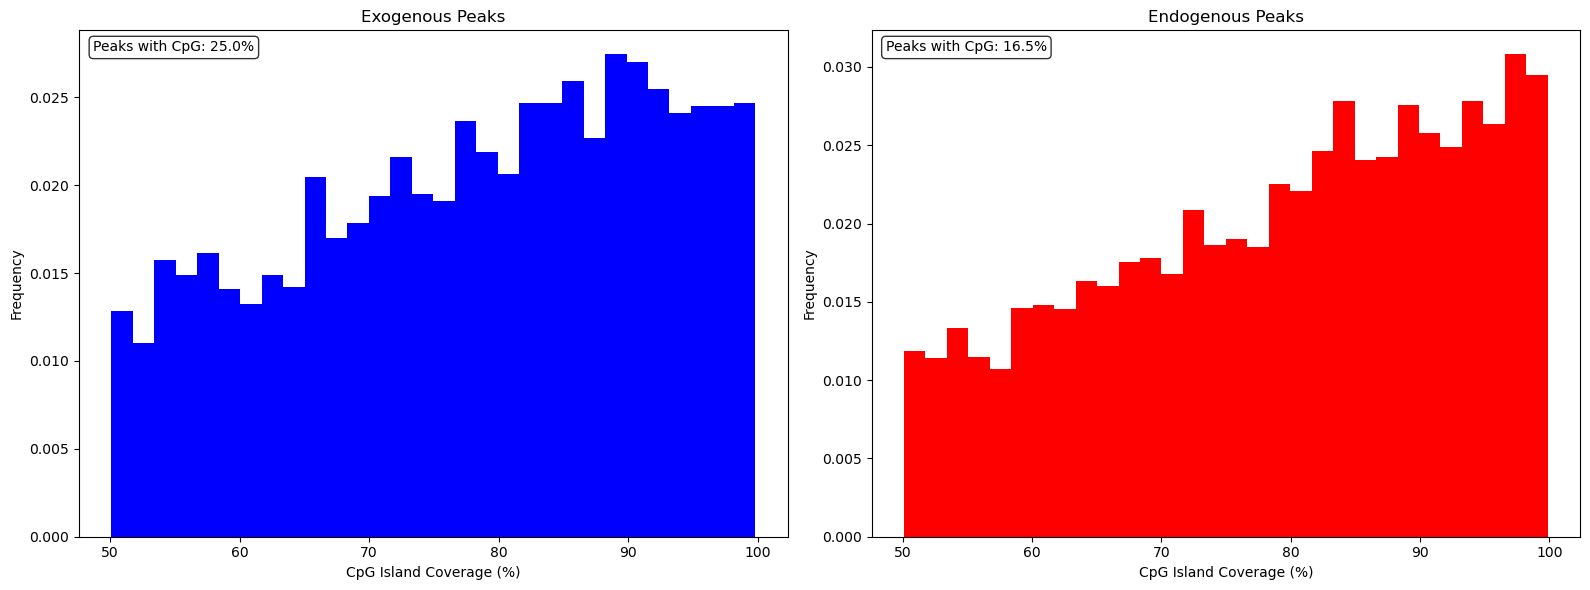

In [86]:
# Create the visualization
plot_coverage_histograms(exo_coverage_nsc, endo_coverage_nsc, min_coverage=50, n_bins=30)

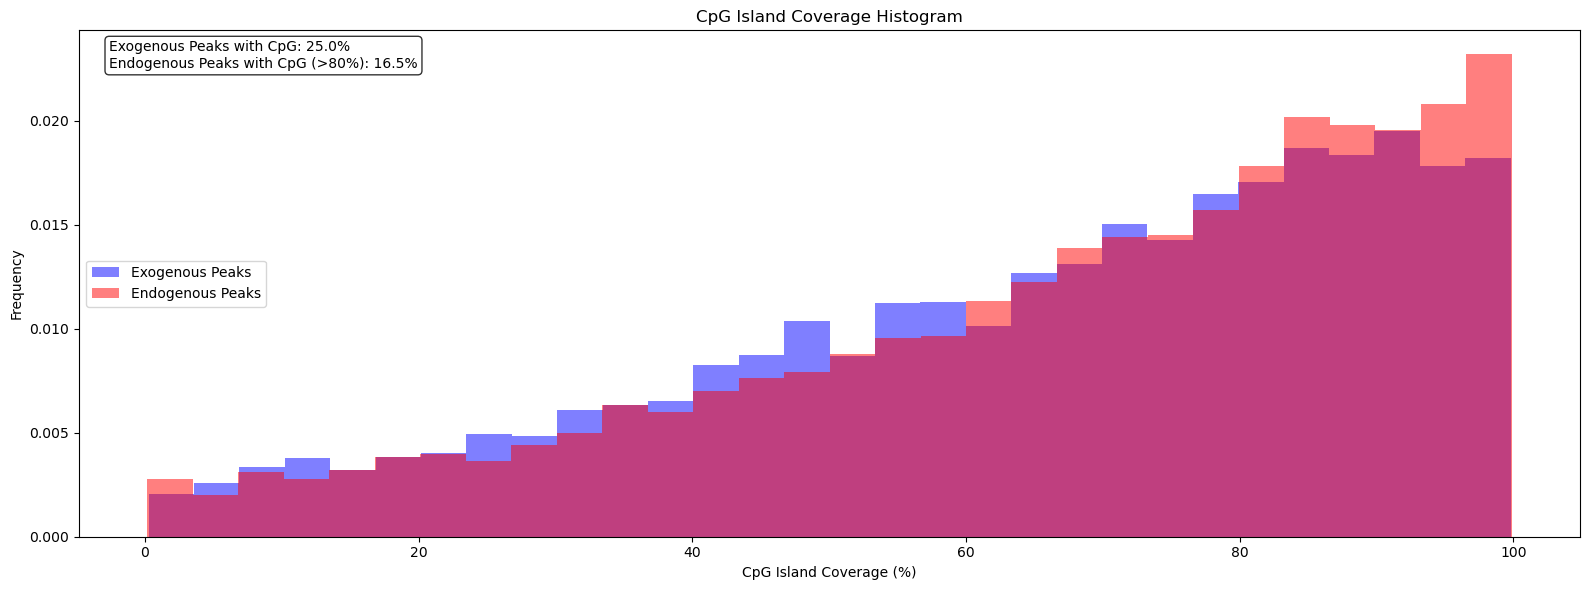

In [87]:
plot_coverage_histograms_overlayed(exo_coverage_nsc, endo_coverage_nsc, min_coverage=0, n_bins=30)

In [88]:
# Save the lists to files
with open('exo_coverage_nsc.pkl', 'wb') as f:
    pickle.dump(exo_coverage_nsc, f)

with open('endo_coverage_nsc.pkl', 'wb') as f:
    pickle.dump(endo_coverage_nsc, f)

In [89]:
# Load the lists back
with open('exo_coverage_nsc.pkl', 'rb') as f:
    exo_coverage_nsc = pickle.load(f)

with open('endo_coverage_nsc.pkl', 'rb') as f:
    endo_coverage_nsc = pickle.load(f)

## Neurons


In [90]:
exo_coverage_neurons = []
for peak_file in exo_samples_neurons['Peaks']:
    # Create temporary filtered peak file
    temp_peak = "temp_filtered_peaks.bed"
    filter_standard_chromosomes(peak_file, temp_peak)
    
    # Calculate coverage using filtered peaks
    coverage = calculate_peak_cpg_coverage(temp_peak, cpg_file, extend=100)
    exo_coverage_neurons.extend(coverage)
    
    # Clean up
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

Filtered results/peaks/NeuV1_peaks.narrowPeak: kept 56178/56234 peaks (99.9%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


Filtered results/peaks/NeuV2_peaks.narrowPeak: kept 71591/71695 peaks (99.9%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


Filtered results/peaks/NeuV3_peaks.narrowPeak: kept 77234/77302 peaks (99.9%)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [91]:
exo_coverage_neurons[:10]

[0.0, 0.0, 0.0, 0.0, 88.43537414965986, 100.0, 100.0, 0.0, 0.0, 0.0]

In [92]:
%%capture
endo_coverage_neurons = []
for peak_file in endo_samples_neurons['Peaks']:
    # Create temporary filtered peak file
    temp_peak = "temp_filtered_peaks.bed"
    filter_standard_chromosomes(peak_file, temp_peak)
    
    # Calculate coverage using filtered peaks
    coverage = calculate_peak_cpg_coverage(temp_peak, cpg_file, extend=100)
    endo_coverage_neurons.extend(coverage)
    
    # Clean up
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [93]:
endo_coverage_neurons[:10]


[0.0,
 0.0,
 0.0,
 90.27237354085604,
 0.0,
 93.02721088435374,
 100.0,
 100.0,
 100.0,
 0.0]

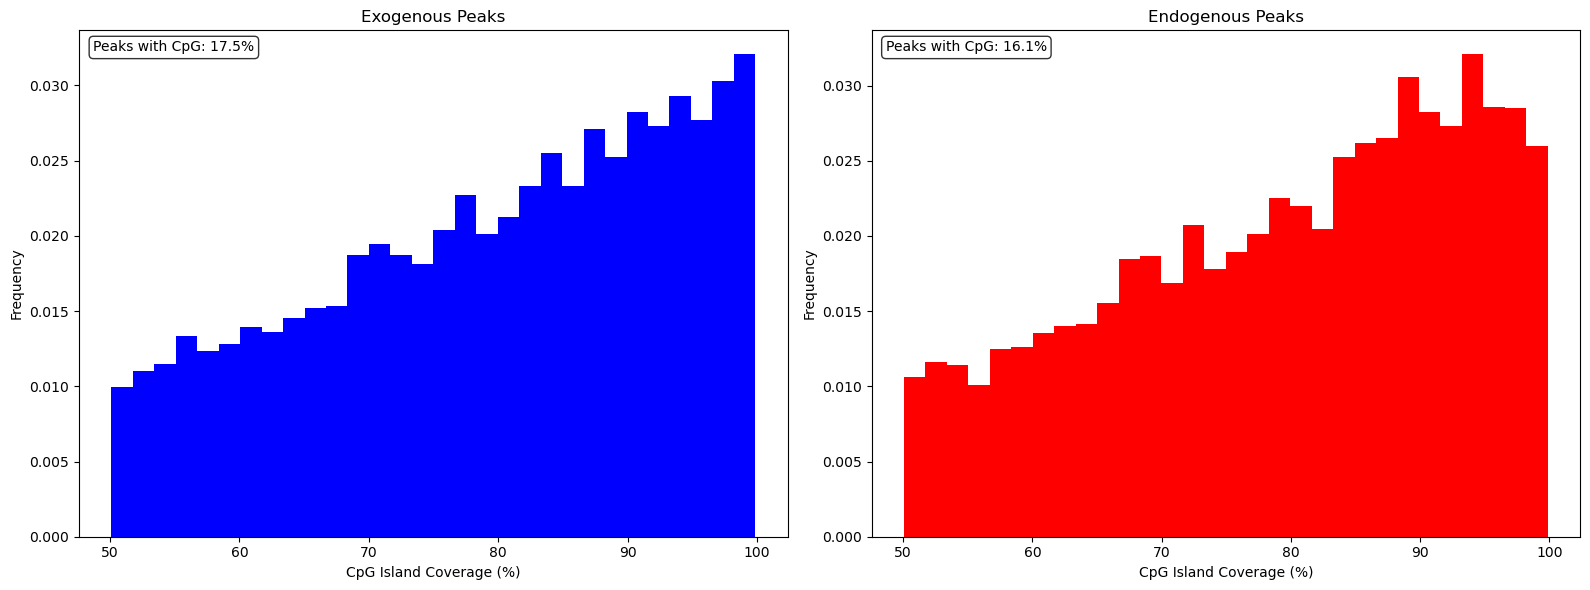

In [94]:
# Create the visualization
plot_coverage_histograms(exo_coverage_neurons, endo_coverage_neurons, min_coverage=50, n_bins=30)

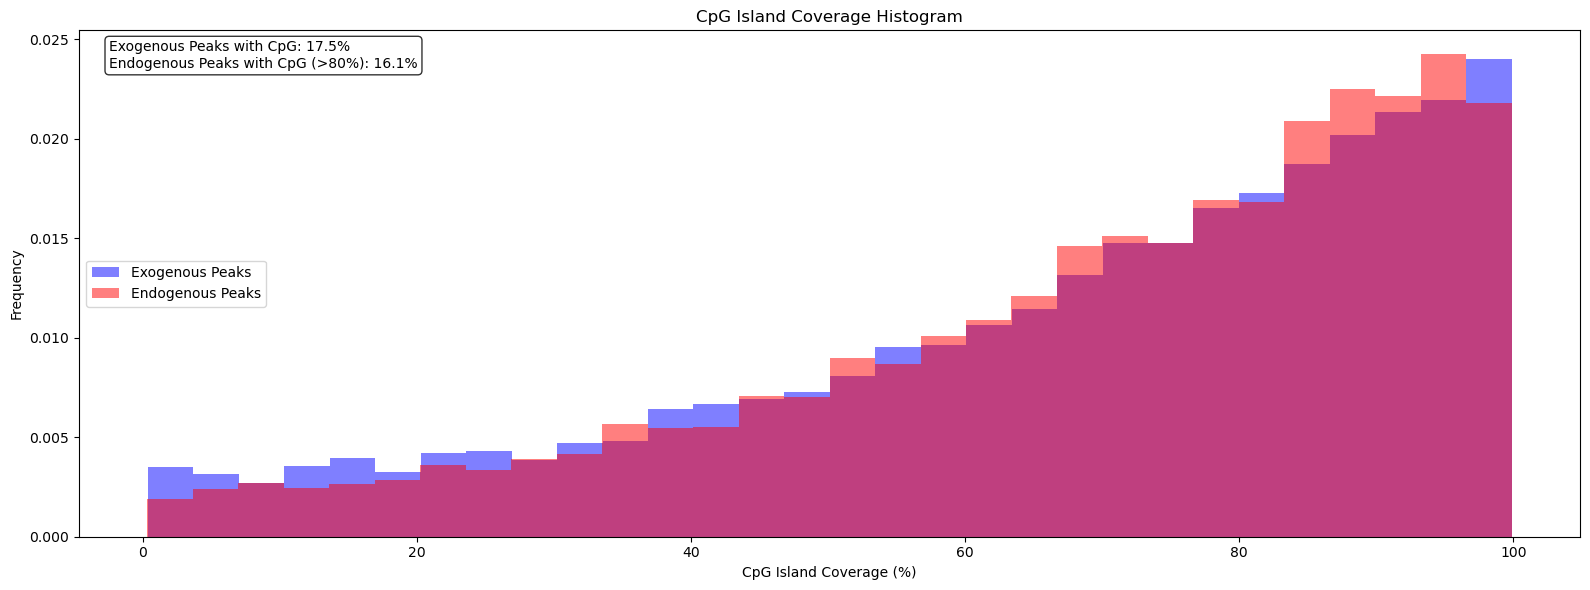

In [95]:
plot_coverage_histograms_overlayed(exo_coverage_neurons, endo_coverage_neurons, min_coverage=0, n_bins=30)

In [96]:
# Save the lists to files
with open('exo_coverage_neurons.pkl', 'wb') as f:
    pickle.dump(exo_coverage_neurons, f)

with open('endo_coverage_neurons.pkl', 'wb') as f:
    pickle.dump(endo_coverage_neurons, f)

In [97]:

# Load the lists back
with open('exo_coverage_neurons.pkl', 'rb') as f:
    exo_coverage_neurons = pickle.load(f)

with open('endo_coverage_neurons.pkl', 'rb') as f:
    endo_coverage_nsc = pickle.load(f)

# Only with the common peaks

### NSC


In [98]:
# Read the gene list
genes_df_nsc = pd.read_csv("DATA/allgenes_NSC_total.csv")

# Filter for genes that have both types of promoters
common_genes_nsc = genes_df_nsc[
    (genes_df_nsc['Endogenous_Promoter'] == True) & 
    (genes_df_nsc['Exogenous_Promoter'] == True)
]
print(f"Number of genes with both promoter types: {len(common_genes_nsc)}")
print("Example genes:", common_genes_nsc['gene'].head().tolist())

Number of genes with both promoter types: 2231
Example genes: ['Aak1', 'Abat', 'Abca1', 'Abca3', 'Abca4']


In [99]:
common_genes_nsc.head()


,gene,baseMean,log2FoldChange,Direction,Endogenous_Promoter,Exogenous_Promoter
0,Aak1,9040.147360,0.523064,UP,True,True
2,Abat,2381.129589,1.737878,UP,True,True
3,Abca1,1217.144188,2.799356,UP,True,True
5,Abca3,1274.604870,1.025460,UP,True,True
6,Abca4,107.938485,-1.498484,DOWN,True,True


In [100]:
%%capture
exo_coverage_nsc = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, common_genes_nsc, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_nsc.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [101]:
exo_coverage_nsc[:10]


[100.0, 100.0, 0.0, 0.0, 0.0, 0.0, 100.0, 100.0, 100.0, 0.0]

In [102]:
%%capture
endo_coverage_nsc = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, common_genes_nsc, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file)
    endo_coverage_nsc.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


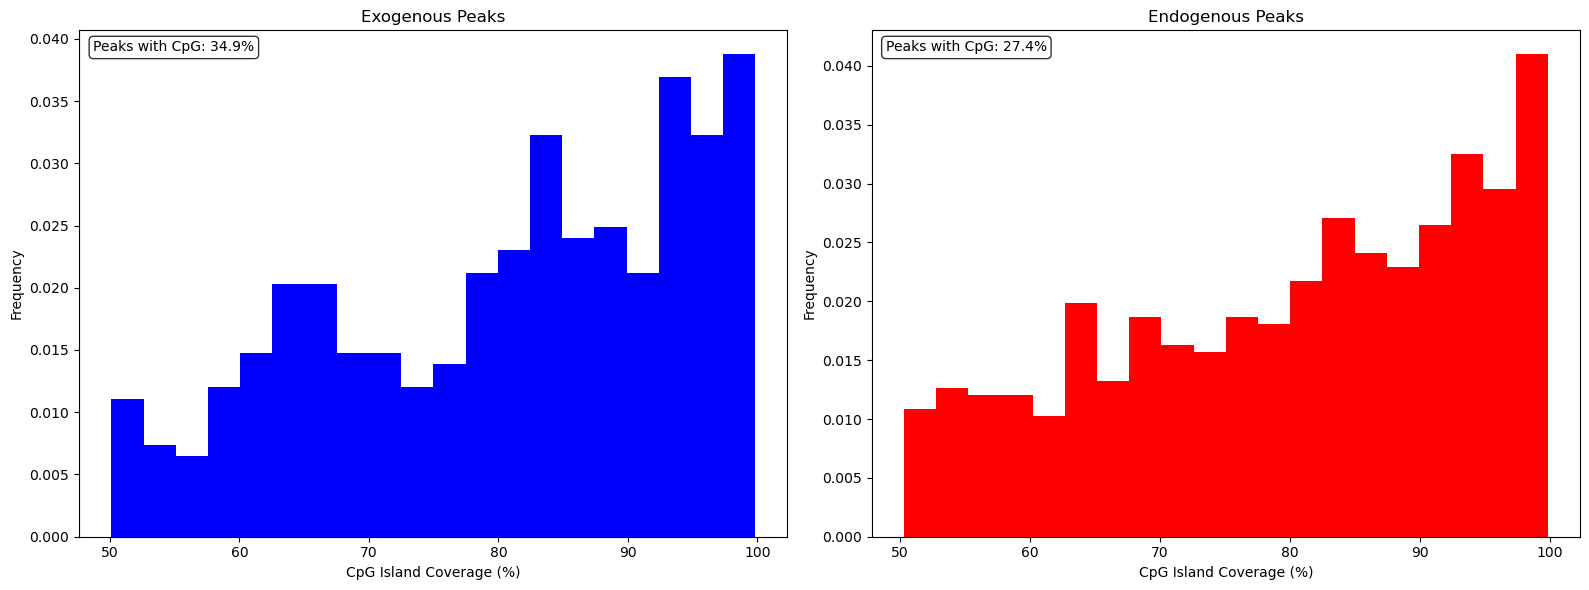

In [103]:
# Create the visualization
plot_coverage_histograms(exo_coverage_nsc, endo_coverage_nsc, min_coverage=50, n_bins=20)

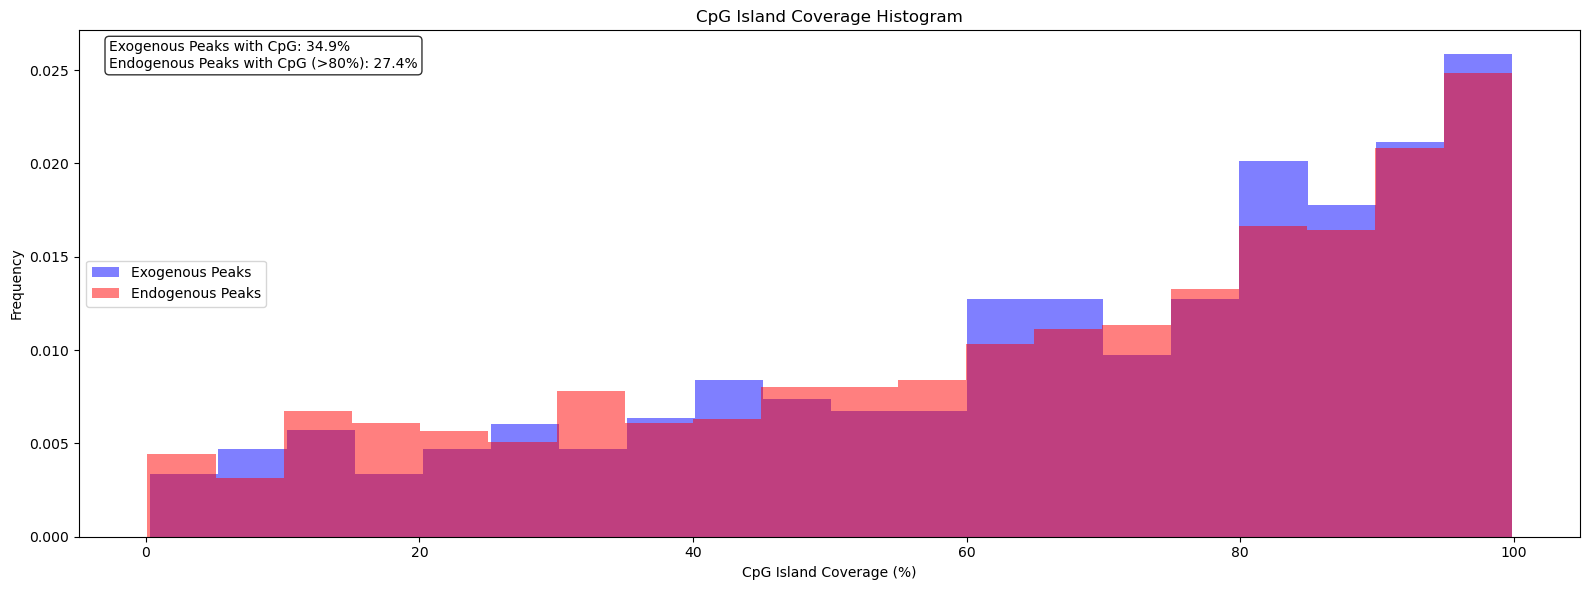

In [104]:
plot_coverage_histograms_overlayed(exo_coverage_nsc, endo_coverage_nsc, min_coverage=0, n_bins=20)

In [105]:
# Save the lists to files
with open('selected_exo_coverage_nsc.pkl', 'wb') as f:
    pickle.dump(exo_coverage_nsc, f)

with open('selected_endo_coverage_nsc.pkl', 'wb') as f:
    pickle.dump(endo_coverage_nsc, f)

In [106]:
# Load the lists back
with open('selected_exo_coverage_nsc.pkl', 'rb') as f:
    exo_coverage_nsc = pickle.load(f)

with open('selected_endo_coverage_nsc.pkl', 'rb') as f:
    endo_coverage_nsc = pickle.load(f)

### Neurons


In [107]:
# Read the gene list
genes_df_neurons = pd.read_csv("DATA/allgenes_NEU_total.csv")

# Filter for genes that have both types of promoters
common_genes_neurons = genes_df_neurons[
    (genes_df_neurons['Endogenous_Promoter'] == True) & 
    (genes_df_neurons['Exogenous_Promoter'] == True)
]
print(f"Number of genes with both promoter types: {len(common_genes_neurons)}")
print("Example genes:", common_genes_neurons['gene'].head().tolist())

Number of genes with both promoter types: 285
Example genes: ['Abcc4', 'Adamts10', 'Adamtsl2', 'Adgrl2', 'Adrb1']


In [108]:
%%capture
exo_coverage_neurons = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, common_genes_neurons, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_neurons.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [109]:
%%capture
endo_coverage_neurons = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, common_genes_neurons, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file)
    endo_coverage_neurons.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


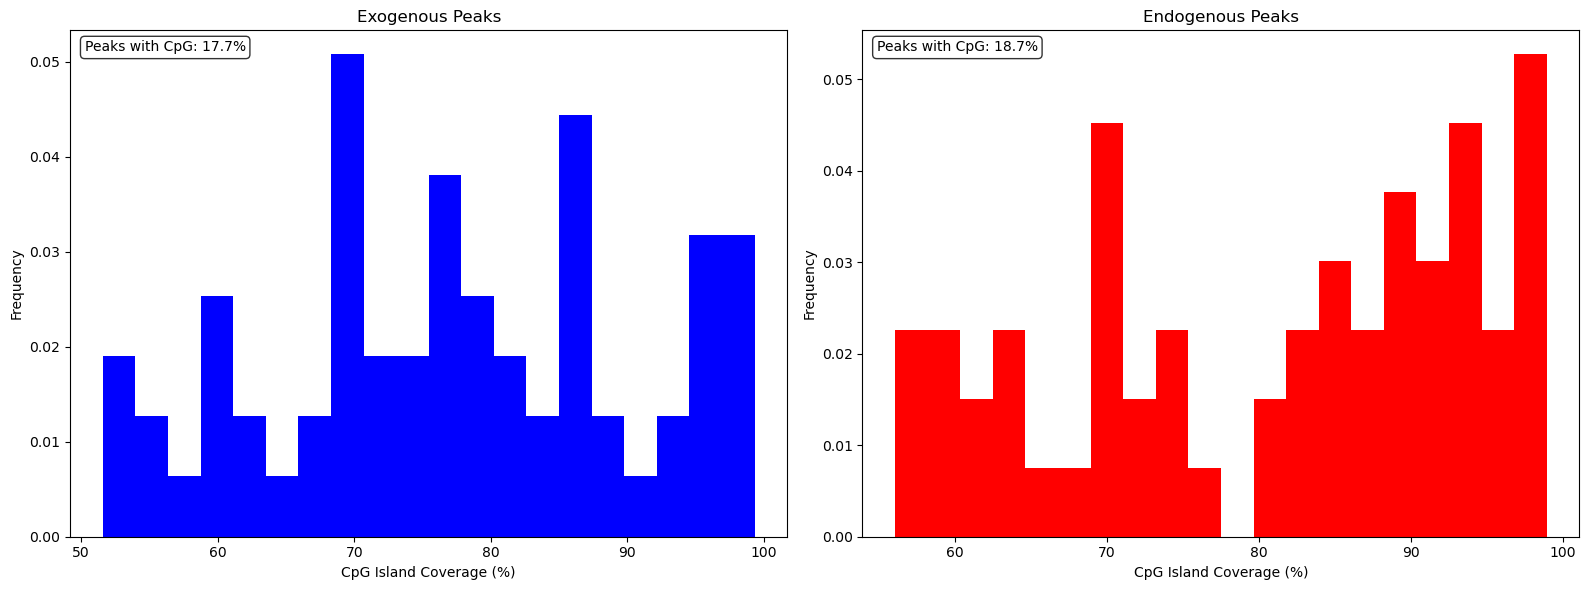

In [110]:
plot_coverage_histograms(exo_coverage_neurons, endo_coverage_neurons, min_coverage=50, n_bins=20)

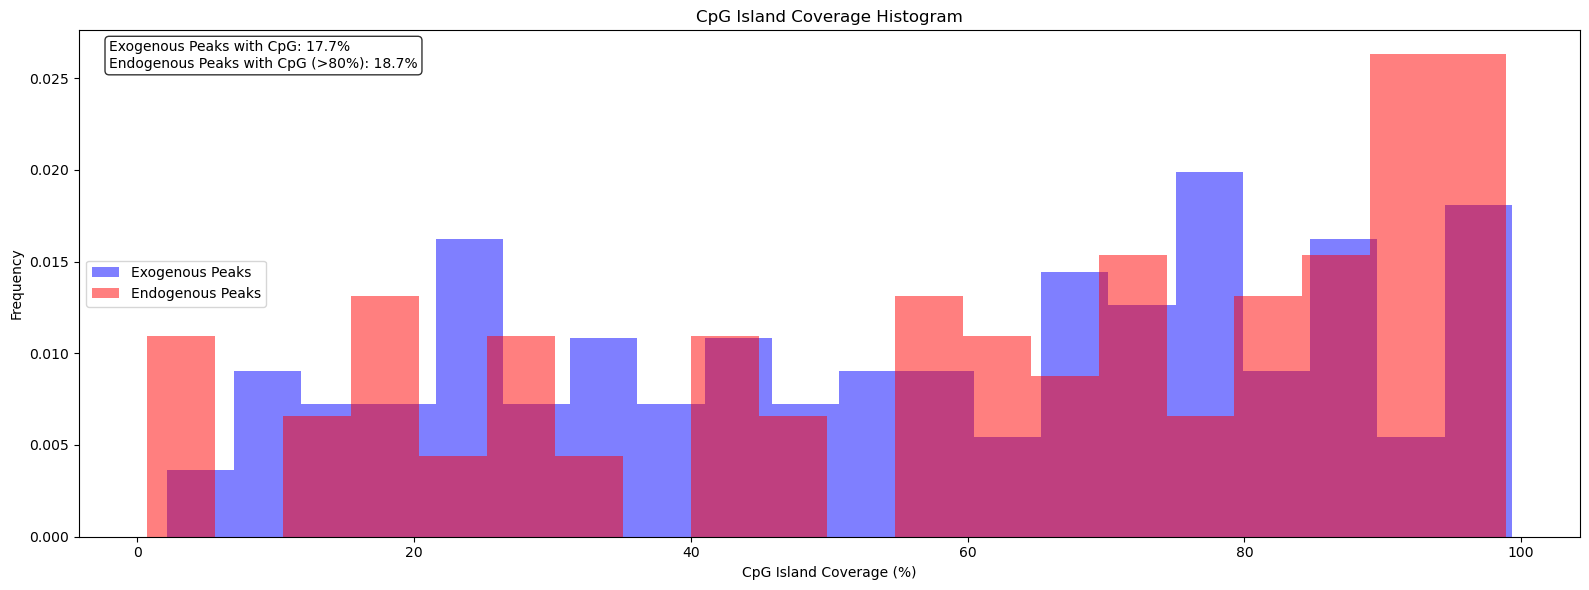

In [111]:
plot_coverage_histograms_overlayed(exo_coverage_neurons, endo_coverage_neurons, min_coverage=0, n_bins=20)


In [112]:
# Save the lists to files
with open('selected_exo_coverage_neurons.pkl', 'wb') as f:
    pickle.dump(exo_coverage_neurons, f)

with open('selected_endo_coverage_neurons.pkl', 'wb') as f:
    pickle.dump(endo_coverage_neurons, f)

In [113]:

# Load the lists back
with open('selected_exo_coverage_neurons.pkl', 'rb') as f:
    exo_coverage_neurons = pickle.load(f)

with open('selected_endo_coverage_neurons.pkl', 'rb') as f:
    endo_coverage_neurons = pickle.load(f)

# DE expression bins

In [114]:
DEA_NEU = pd.read_csv("./DATA/DEA_NEU.csv", header=0)
DEA_NSC = pd.read_csv("./DATA/DEA_NSC.csv", header=0)

In [115]:
DEA_NSC.head()

,gene,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj
0,Mir5125,128.824113,0.000073,0.189117,0.000383,0.999694,0.999694
1,Trim68,98.639563,0.000133,0.215486,0.000617,0.999508,0.999614
2,Frrs1,442.946120,0.000097,0.109825,0.000883,0.999295,0.999556
3,Notch4,60.968185,0.000246,0.266300,0.000925,0.999262,0.999556
4,Ano6,5982.860518,0.000074,0.070708,0.001043,0.999168,0.999503


In [116]:
q33_, q66 = DEA_NSC['baseMean'].quantile([0.33, 0.66])
DEA_NSC['expression_level'] = DEA_NSC['baseMean'].apply(get_expression_level)

q33, q66 = DEA_NEU['baseMean'].quantile([0.33, 0.66])
DEA_NEU['expression_level'] = DEA_NEU['baseMean'].apply(get_expression_level)

## UP

In [117]:
DEA_NEU_up = DEA_NEU[(DEA_NEU['padj'] < 0.05) & (DEA_NEU['log2FoldChange'] > 0)]
DEA_NSC_up = DEA_NSC[(DEA_NSC['padj'] < 0.05) & (DEA_NSC['log2FoldChange'] > 0)]

### NSC

In [118]:
# Calculate quantiles for expression binning
# q33, q66 = DEA_NSC_up['baseMean'].quantile([0.33, 0.66])

In [119]:
# # Let's see the distribution
# print("Expression level boundaries:")
# print(f"Low: baseMean <= {q33:.2f}")
# print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
# print(f"High: baseMean > {q66:.2f}")
# print("\nNumber of genes in each category:")
# print(DEA_NSC_up['expression_level'].value_counts())

In [120]:
DEA_NSC_up_high = DEA_NSC_up[DEA_NSC_up.expression_level == 'High']
DEA_NSC_up_medium = DEA_NSC_up[DEA_NSC_up.expression_level == 'Medium']
DEA_NSC_up_low = DEA_NSC_up[DEA_NSC_up.expression_level == 'Low']

In [121]:
%%capture
# Calculate coverage for filtered peaks
exo_coverage_up_high = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_up_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_up_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_up_medium = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_up_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_up_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)
    
# Calculate coverage for filtered peaks
exo_coverage_up_low = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_up_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_up_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [122]:
%%capture
# Calculate coverage for filtered peaks
endo_coverage_up_high = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_up_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_up_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_up_medium = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_up_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_up_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_up_low = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_up_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_up_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


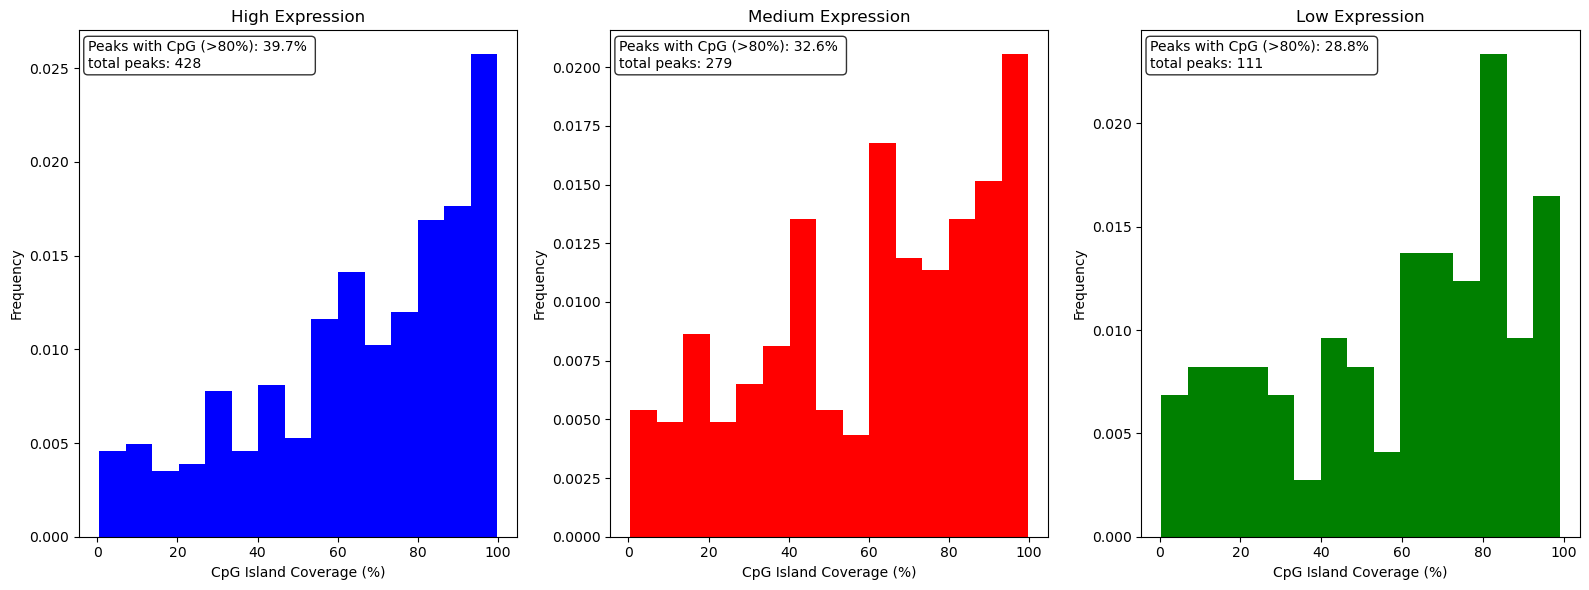

In [123]:
# Exogenous
fig = plot_coverage_histograms_expression(exo_coverage_up_high, exo_coverage_up_medium, exo_coverage_up_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


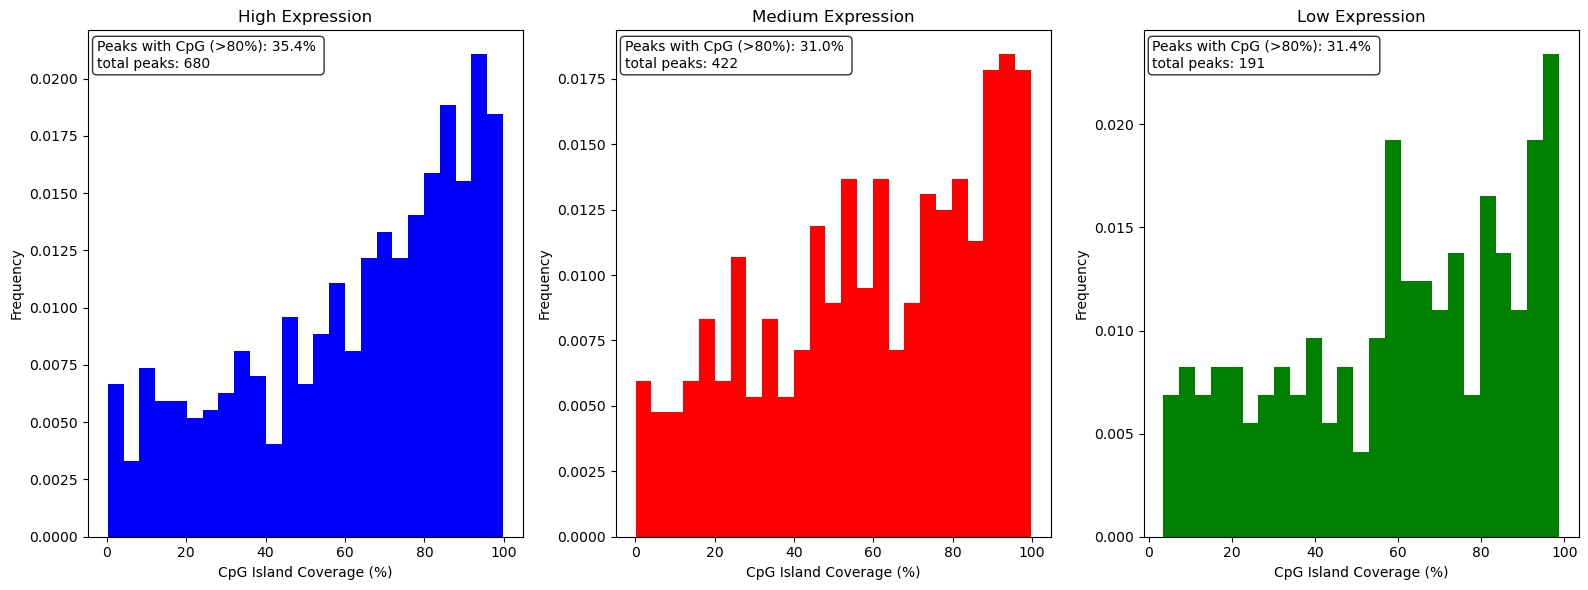

In [124]:
# Endogenous
fig = plot_coverage_histograms_expression(endo_coverage_up_high, endo_coverage_up_medium, endo_coverage_up_low, min_coverage=0, p_t = 80, n_bins=25)
plt.show()


In [125]:
# Save the lists to files
with open('expression_coverage_up_high_nsc.pkl', 'wb') as f:
    pickle.dump(exo_coverage_up_high, f)

with open('expression_coverage_up_medium_nsc.pkl', 'wb') as f:
    pickle.dump(exo_coverage_up_medium, f)

with open('expression_coverage_up_low_nsc.pkl', 'wb') as f:
    pickle.dump(exo_coverage_up_low, f)



### Neurons


In [126]:
# Calculate quantiles for expression binning
# q33, q66 = DEA_NEU_up['baseMean'].quantile([0.33, 0.66])

In [127]:
%%capture
#  Add expression level column to DEA_NSC
DEA_NEU_up['expression_level'] = DEA_NEU_up['baseMean'].apply(get_expression_level)

In [128]:
# # Let's see the distribution
# print("Expression level boundaries:")
# print(f"Low: baseMean <= {q33:.2f}")
# print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
# print(f"High: baseMean > {q66:.2f}")
# print("\nNumber of genes in each category:")
# print(DEA_NSC_up['expression_level'].value_counts())

In [129]:
DEA_NEU_up_high = DEA_NEU_up[DEA_NEU_up.expression_level == 'High']
DEA_NEU_up_medium = DEA_NEU_up[DEA_NEU_up.expression_level == 'Medium']
DEA_NEU_up_low = DEA_NEU_up[DEA_NEU_up.expression_level == 'Low']

In [130]:
%%capture
# Calculate coverage for filtered peaks
exo_coverage_up_high = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_up_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_up_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_up_medium = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_up_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_up_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)
    
# Calculate coverage for filtered peaks
exo_coverage_up_low = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_up_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_up_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [131]:
%%capture
# Calculate coverage for filtered peaks
endo_coverage_up_high = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_up_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_up_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_up_medium = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_up_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_up_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_up_low = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_up_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_up_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


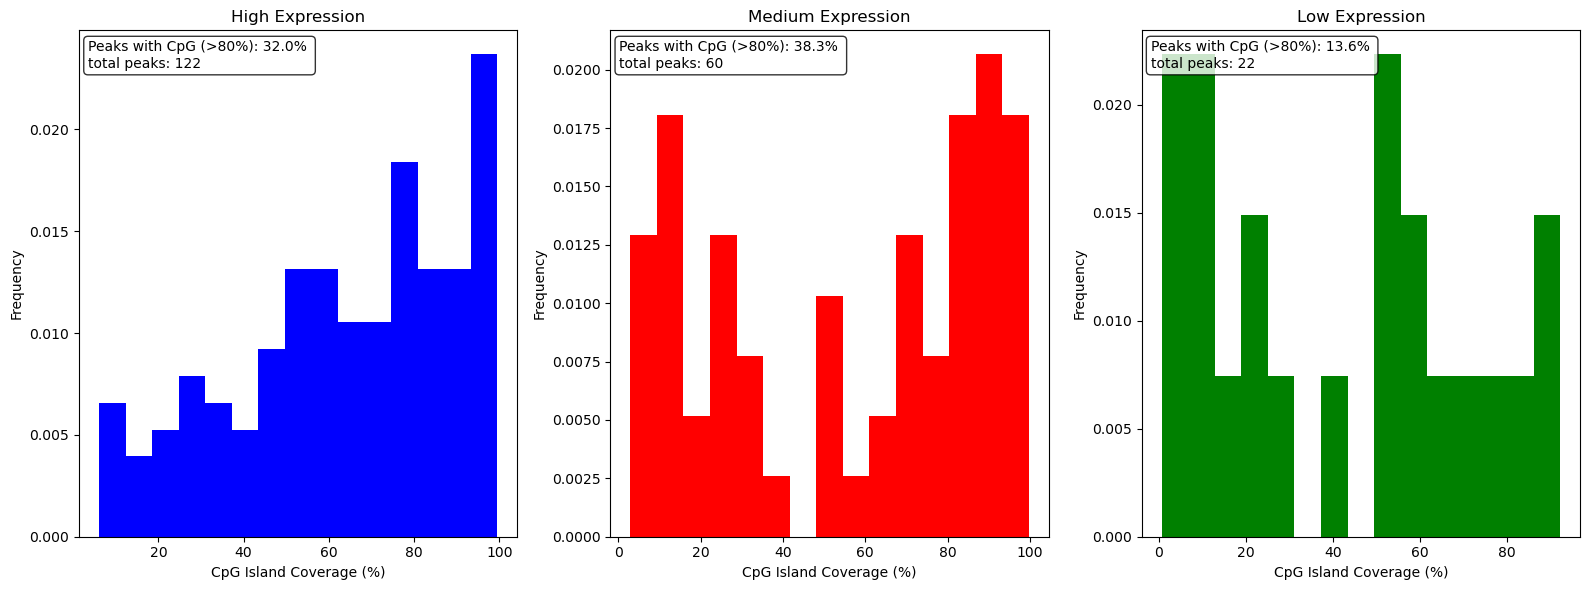

In [132]:
# Exogenous
fig = plot_coverage_histograms_expression(exo_coverage_up_high, exo_coverage_up_medium, exo_coverage_up_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


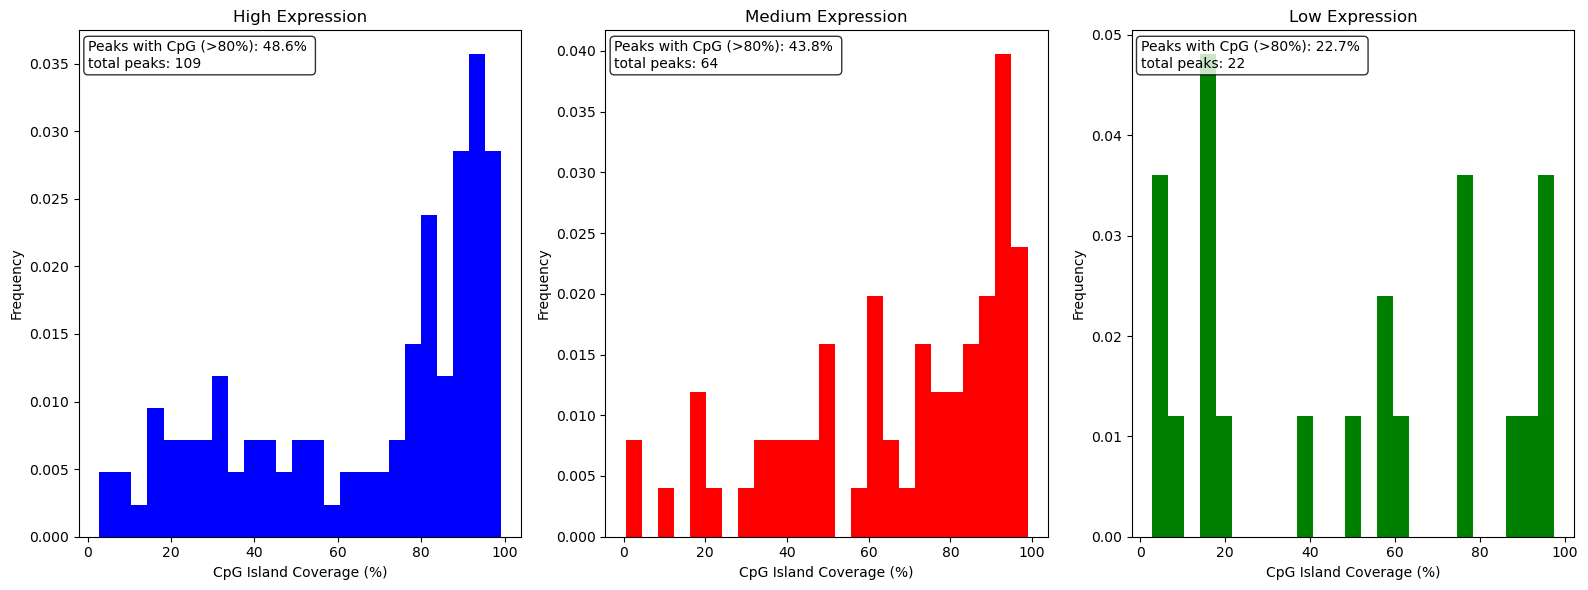

In [133]:
# Endogenous
fig = plot_coverage_histograms_expression(endo_coverage_up_high, endo_coverage_up_medium, endo_coverage_up_low, min_coverage=0, p_t = 80, n_bins=25)
plt.show()


In [134]:
# Save the lists to files
with open('expression_coverage_up_high_neurons.pkl', 'wb') as f:
    pickle.dump(exo_coverage_up_high, f)

with open('expression_coverage_up_medium_neurons.pkl', 'wb') as f:
    pickle.dump(exo_coverage_up_medium, f)

with open('expression_coverage_up_low_neurons.pkl', 'wb') as f:
    pickle.dump(exo_coverage_up_low, f)

## Down

In [135]:
DEA_NEU_down = DEA_NEU[(DEA_NEU['padj'] < 0.05) & (DEA_NEU['log2FoldChange'] < 0)]
DEA_NSC_down = DEA_NSC[(DEA_NSC['padj'] < 0.05) & (DEA_NSC['log2FoldChange'] < 0)]

### NSC


In [136]:
# # Calculate quantiles for expression binning
# q33, q66 = DEA_NSC_down['baseMean'].quantile([0.33, 0.66])

In [137]:
# # Let's see the distribution
# print("Expression level boundaries:")
# print(f"Low: baseMean <= {q33:.2f}")
# print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
# print(f"High: baseMean > {q66:.2f}")
# print("\nNumber of genes in each category:")
# print(DEA_NSC_down['expression_level'].value_counts())

In [138]:
DEA_NSC_down_high = DEA_NSC_down[DEA_NSC_down.expression_level == 'High']
DEA_NSC_down_medium = DEA_NSC_down[DEA_NSC_down.expression_level == 'Medium']
DEA_NSC_down_low = DEA_NSC_down[DEA_NSC_down.expression_level == 'Low']

In [139]:
%%capture
exo_coverage_down_high = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_down_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_down_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_down_medium = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_down_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_down_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_down_low = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_down_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_down_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [140]:
%%capture
# Calculate coverage for filtered peaks
endo_coverage_down_high = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_down_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_down_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_down_medium = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_down_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_down_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_down_low = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_down_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_down_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


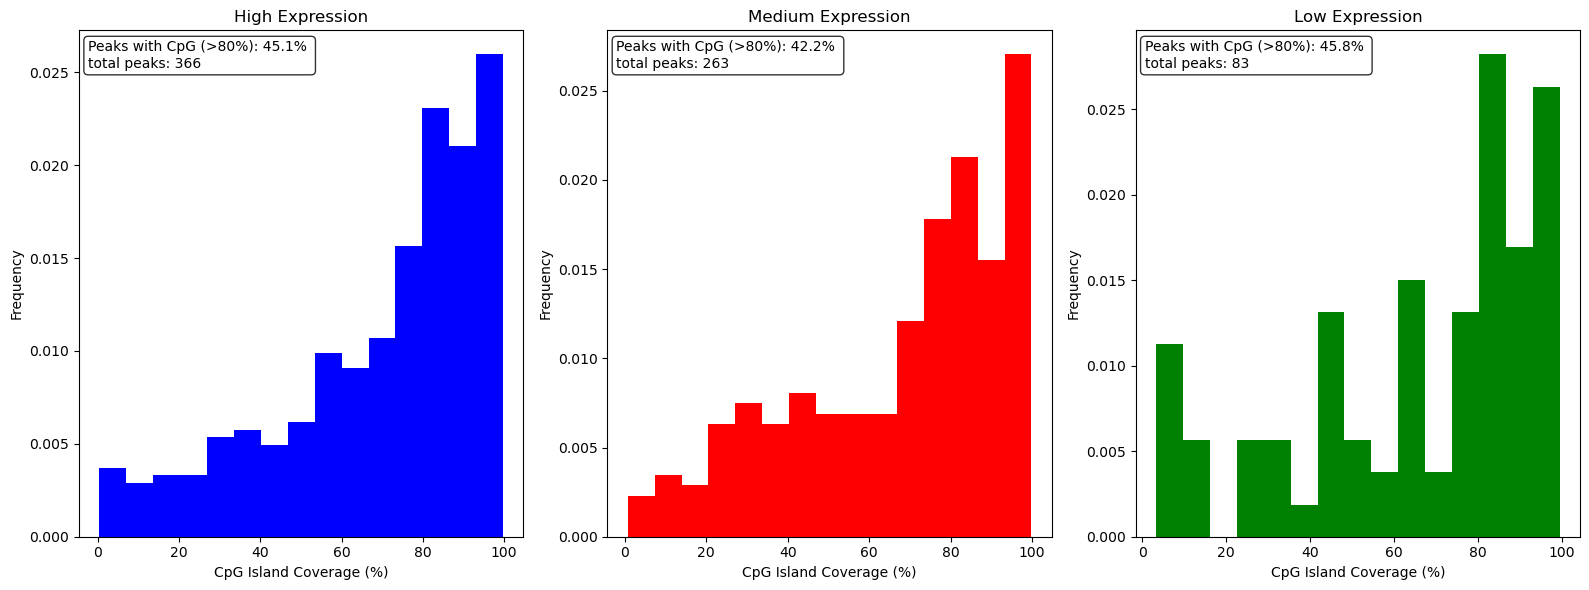

In [141]:
# Exogenous
fig = plot_coverage_histograms_expression(exo_coverage_down_high, exo_coverage_down_medium, exo_coverage_down_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


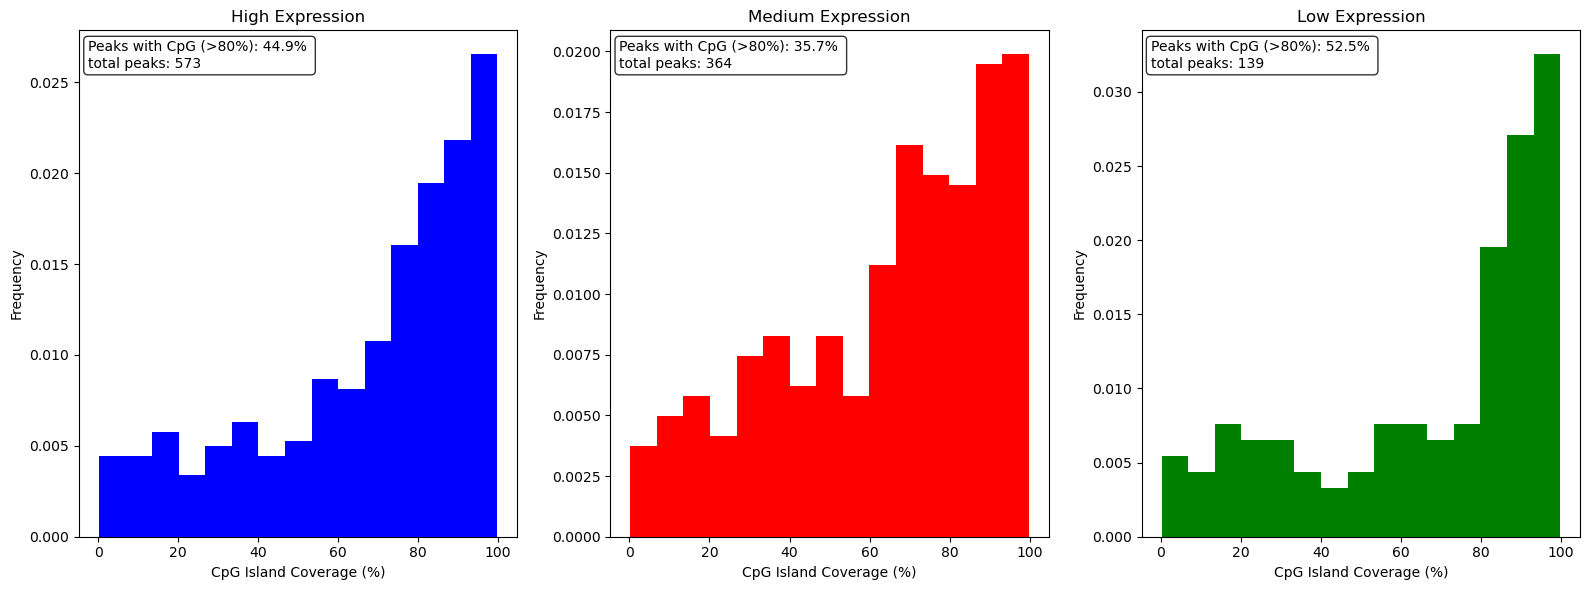

In [142]:
# Endogenous
fig = plot_coverage_histograms_expression(endo_coverage_down_high, endo_coverage_down_medium, endo_coverage_down_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


### Neurons

In [143]:
# # Calculate quantiles for expression binning
# q33, q66 = DEA_NEU_down['baseMean'].quantile([0.33, 0.66])


In [144]:
# Let's see the distribution
# print("Expression level boundaries:")
# print(f"Low: baseMean <= {q33:.2f}")
# print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
# print(f"High: baseMean > {q66:.2f}")
# print("\nNumber of genes in each category:")
# print(DEA_NEU_down['expression_level'].value_counts())

DEA_NEU_down_high = DEA_NEU_down[DEA_NEU_down.expression_level == 'High']
DEA_NEU_down_medium = DEA_NEU_down[DEA_NEU_down.expression_level == 'Medium']
DEA_NEU_down_low = DEA_NEU_down[DEA_NEU_down.expression_level == 'Low']

In [145]:
%%capture
exo_coverage_down_high = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_down_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_down_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_down_medium = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_down_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_down_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_down_low = []
for peak_file in exo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_down_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_down_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [146]:
%%capture
# Calculate coverage for filtered peaks
endo_coverage_down_high = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_down_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_down_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_down_medium = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_down_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_down_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_down_low = []
for peak_file in endo_samples_neurons['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NEU_down_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_down_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


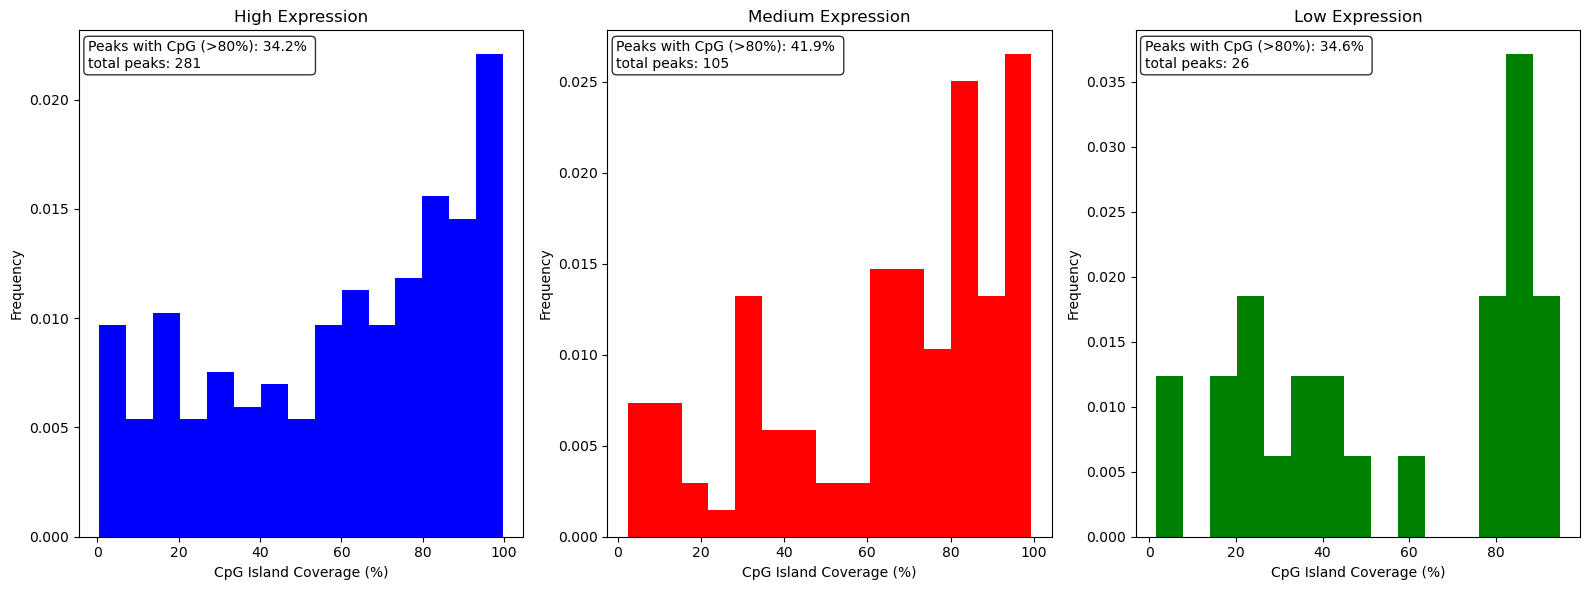

In [147]:
# Exogenous
fig = plot_coverage_histograms_expression(exo_coverage_down_high, exo_coverage_down_medium, exo_coverage_down_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


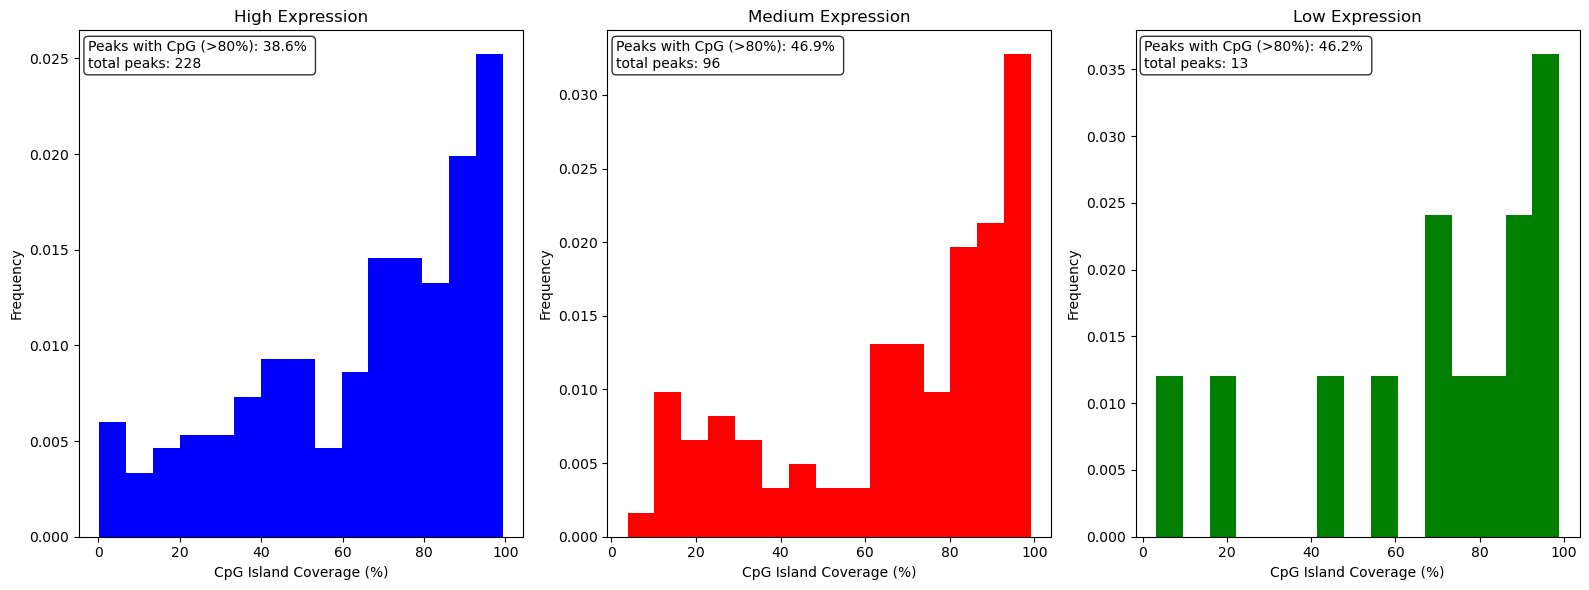

In [148]:
# Endogenous
fig = plot_coverage_histograms_expression(endo_coverage_down_high, endo_coverage_down_medium, endo_coverage_down_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


## Not DE

### NSC

In [149]:
DEA_NEU_not_de = DEA_NEU[DEA_NEU['padj'] > 0.05]
DEA_NSC_not_de = DEA_NSC[DEA_NSC['padj'] > 0.05]

In [150]:
# Calculate quantiles for expression binning
# q33, q66 = DEA_NSC_not_de['baseMean'].quantile([0.33, 0.66])

In [151]:
# # Let's see the distribution
# print("Expression level boundaries:")
# print(f"Low: baseMean <= {q33:.2f}")
# print(f"Medium: {q33:.2f} < baseMean <= {q66:.2f}")
# print(f"High: baseMean > {q66:.2f}")
# print("\nNumber of genes in each category:")
# print(DEA_NSC_not_de['expression_level'].value_counts())

In [152]:
DEA_NSC_not_de_high = DEA_NSC_not_de[DEA_NSC_not_de.expression_level == 'High']
DEA_NSC_not_de_medium = DEA_NSC_not_de[DEA_NSC_not_de.expression_level == 'Medium']
DEA_NSC_not_de_low = DEA_NSC_not_de[DEA_NSC_not_de.expression_level == 'Low']

In [153]:
%%capture
exo_coverage_not_de_high = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_not_de_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_not_de_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_not_de_medium = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_not_de_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_not_de_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
exo_coverage_not_de_low = []
for peak_file in exo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_not_de_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    exo_coverage_not_de_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


In [154]:
%%capture
# Calculate coverage for filtered peaks
endo_coverage_not_de_high = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_not_de_high, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_not_de_high.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_not_de_medium = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_not_de_medium, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_not_de_medium.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)

# Calculate coverage for filtered peaks
endo_coverage_not_de_low = []
for peak_file in endo_samples_nsc['Peaks']:
    filtered_peaks = get_common_peaks(peak_file, DEA_NSC_not_de_low, "DATA/genes.bed")
    coverage = calculate_peak_cpg_coverage(filtered_peaks, cpg_file,)
    endo_coverage_not_de_low.extend(coverage)
    subprocess.run("rm temp_filtered_peaks.bed", shell=True)


* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *
* Input error: Chromosome chr10_KQ030491_fix doesn't present in the .genome file. *


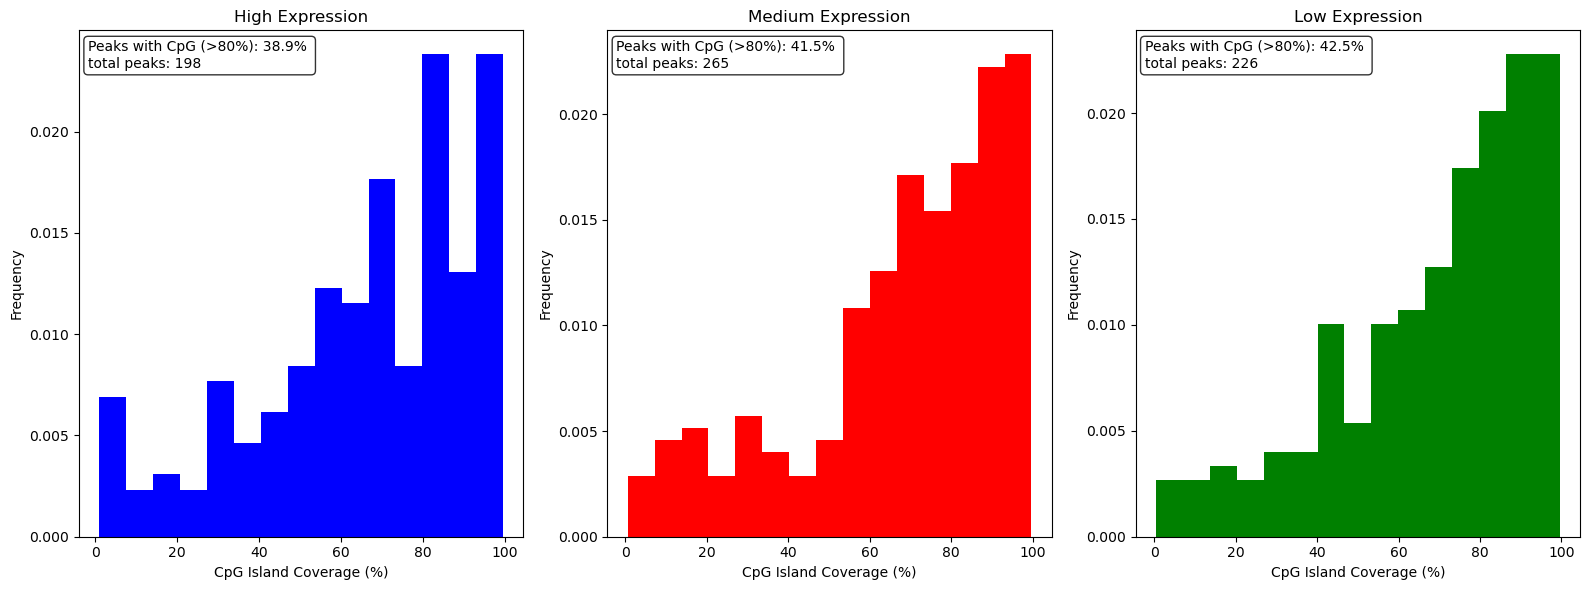

In [155]:
# Exogenous
fig = plot_coverage_histograms_expression(exo_coverage_not_de_high, exo_coverage_not_de_medium, exo_coverage_not_de_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


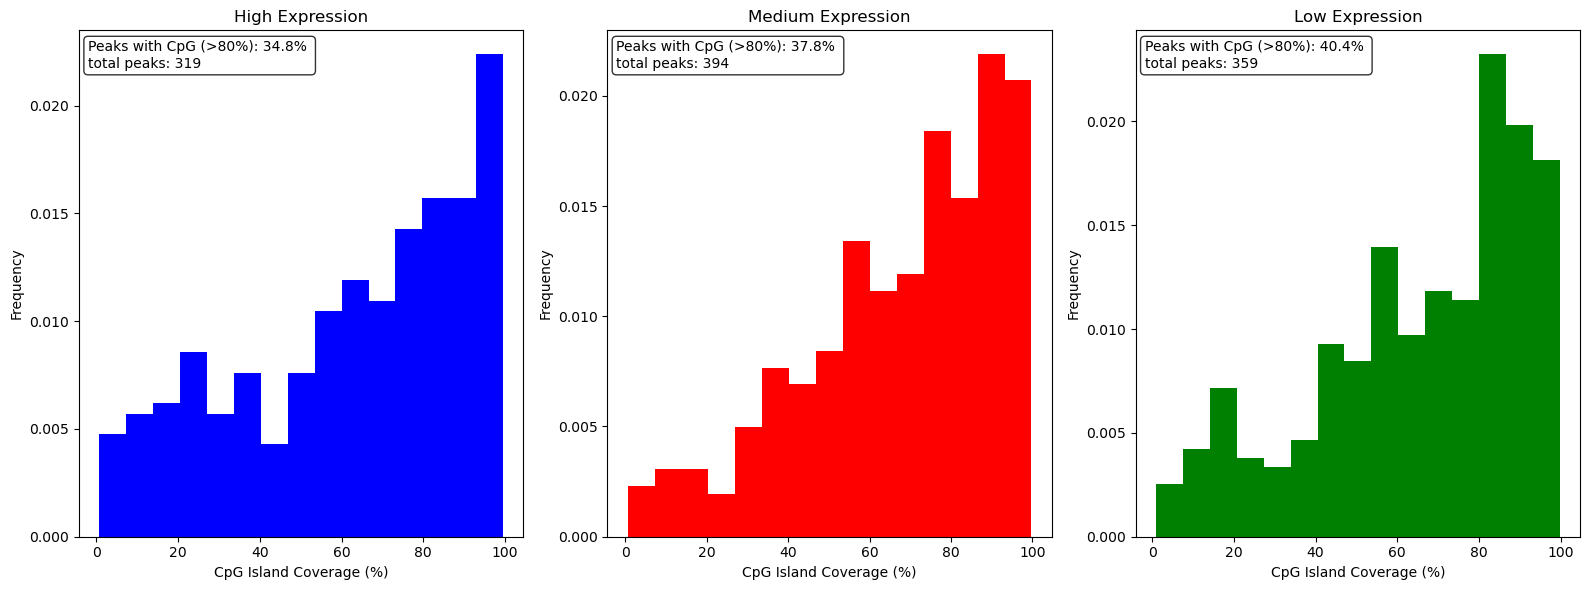

In [156]:
# Endogenous
fig = plot_coverage_histograms_expression(endo_coverage_not_de_high, endo_coverage_not_de_medium, endo_coverage_not_de_low, min_coverage=0, p_t = 80, n_bins=15)
plt.show()


# Plot peaks signals

In [157]:
import gzip
import numpy as np

def plot_peak_signals(peak_file, bigwig_files, window_size=1000, num_peaks=5):
    """
    Plot signal profiles for selected peaks across multiple bigWig files
    """
    import gzip  # Add this import at the top
    
    # Select random peaks
    cmd = f"shuf -n {num_peaks} {peak_file} > temp_random_peaks.bed"
    subprocess.run(cmd, shell=True)
    
    # Center peaks and extend by window_size
    half_window = window_size // 2
    signals = {}
    
    for bw_file in bigwig_files:
        # Use deepTools computeMatrix to get signal values
        matrix_file = "temp_matrix.gz"
        cmd = (f"computeMatrix reference-point"
               f" --referencePoint center"
               f" -b {half_window} -a {half_window}"
               f" -R temp_random_peaks.bed"
               f" -S {bw_file}"
               f" --skipZeros"
               f" -o {matrix_file}")
        
        # Run command and check for errors
        result = subprocess.run(cmd, shell=True, capture_output=True, text=True)
        if result.returncode != 0:
            print(f"Error running computeMatrix for {bw_file}:")
            print(result.stderr)
            continue
            
        try:
            # Read the gzipped matrix
            data = []
            with gzip.open(matrix_file, 'rt') as f:
                for line in f:
                    if not line.startswith(('@', '#')):
                        values = line.strip().split('\t')[6:]  # Skip region info columns
                        data.append([float(x) for x in values])
            
            if data:  # Only store if we got some data
                signals[os.path.basename(bw_file)] = np.array(data)
            
        except Exception as e:
            print(f"Error processing matrix file for {bw_file}:")
            print(str(e))
            continue
        finally:
            # Clean up matrix file
            if os.path.exists(matrix_file):
                os.remove(matrix_file)
    
    if not signals:
        print("No valid signal data was obtained.")
        return
        
    # Create figure
    fig, axes = plt.subplots(num_peaks, 1, figsize=(10, 3*num_peaks))
    if num_peaks == 1:
        axes = [axes]
    
    # Create x-axis values (distance from center)
    bins = signals[list(signals.keys())[0]].shape[1]
    x = np.linspace(-half_window, half_window, bins)
    
    # Plot each peak
    for i in range(num_peaks):
        for bw_file, signal in signals.items():
            if i < len(signal):  # Make sure we have enough peaks
                axes[i].plot(x, signal[i], label=os.path.basename(bw_file))
                
        axes[i].axvline(x=0, color='gray', linestyle='--', alpha=0.5)
        axes[i].set_xlabel('Distance from peak center (bp)')
        axes[i].set_ylabel('Signal')
        axes[i].legend()
    
    plt.tight_layout()
    plt.show()
    
    # # Final cleanup
    # if os.path.exists("temp_random_peaks.bed"):
    #     os.remove("temp_random_peaks.bed")



In [158]:
# Get peaks for genes with both promoter types
filtered_peaks = get_common_peaks(exo_samples['Peaks'].iloc[0], common_genes, "DATA/genes.bed")

NameError: name 'common_genes' is not defined

In [ ]:
# Use the function
bigwig_dir = "results/bigwig"
bigwig_files = [
    f"{bigwig_dir}/Exogenous_Neuron.bw",
    f"{bigwig_dir}/Endogenous_Neuron.bw"
]

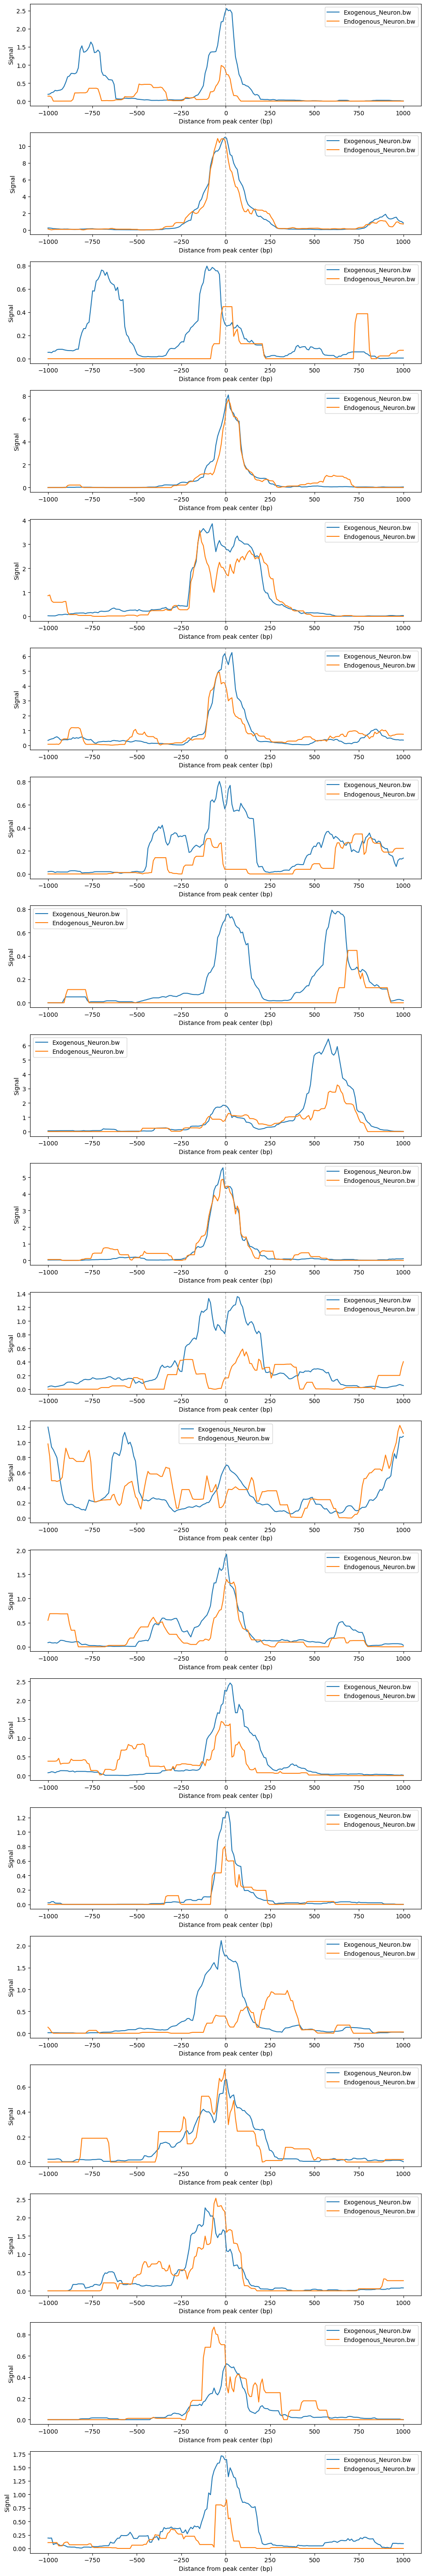

In [238]:
# Plot the signals
plot_peak_signals(filtered_peaks, bigwig_files, window_size=2000, num_peaks=20)